In [2]:
# ======================================================================= #
# Course: Deep Learning Complete Course (CS-501)
# Author: Dr. Saad Laouadi
# Lesson: Deep Learning Regression Tutorial
#
# Description: Training Linear Regression with Keras 3 API
#    """
#    Project Description:
#    ------------------
#    This notebook demonstrates how to build a deep learning regression model using TensorFlow/Keras.
#    We'll generate synthetic data using scikit-learn, then build, train, and evaluate a neural network
#    for regression tasks. This tutorial is designed for educational purposes to help understand the
#    complete workflow of creating deep learning models for regression problems.
#
#    Objectives:
#    ----------
#    1. Learn how to generate synthetic regression data
#    2. Understand deep learning model architecture for regression
#    3. Learn the proper steps for data preprocessing
#    4. Build and compile a neural network using Keras
#    5. Train and evaluate the model's performance
#    6. Visualize the results and model predictions
#   #  Additional Concepts to understand how: 
#      - How to properly evaluate regression models
#      - Techniques to prevent overfitting
#      - The importance of cross-validation
#      - How to analyze model predictions and errors
#      - How to interpret feature importance
#      - How to save and reuse models
#    """
# =======================================================================
#.          Copyright © Dr. Saad Laouadi 2024
# =======================================================================

In [68]:
# 1. Environment Setup
# ------------------
import os  
import sys 
from pathlib import Path
from pprint import pprint

# Disable Metal API Validation
os.environ["METAL_DEVICE_WRAPPER_TYPE"] = "0"

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


print("="*72)

%reload_ext watermark
%watermark -a "Dr. Saad Laouadi" -u -d -m

print("="*72)
print("Imported Packages and Their Versions:")
print("="*72)

%watermark -iv
print("="*72)

Author: Dr. Saad Laouadi

Last updated: 2024-11-30

Compiler    : Clang 14.0.6 
OS          : Darwin
Release     : 24.1.0
Machine     : arm64
Processor   : arm
CPU cores   : 16
Architecture: 64bit

Imported Packages and Their Versions:
seaborn   : 0.13.2
scipy     : 1.13.1
sklearn   : 1.5.1
tensorflow: 2.16.2
keras     : 3.6.0
sys       : 3.11.10 (main, Oct  3 2024, 02:26:51) [Clang 14.0.6 ]
matplotlib: 3.9.2
pandas    : 2.2.2
numpy     : 1.26.4



In [4]:
# 2. Data Generation Function
# -------------------------
def generate_regression_data(n_samples=1000, n_features=1, noise=20.0, random_state=42):
    """
    Generate synthetic regression data using sklearn's make_regression.
    
    Parameters:
    -----------
    n_samples : int
        Number of samples to generate
    n_features : int
        Number of features (independent variables)
    noise : float
        Standard deviation of gaussian noise
    random_state : int
        Random seed for reproducibility
        
    Returns:
    --------
    X : ndarray of shape (n_samples, n_features)
        Generated samples
    y : ndarray of shape (n_samples,)
        Target values
    """
    X, y = make_regression(
        n_samples=n_samples,
        n_features=n_features,
        noise=noise,
        random_state=random_state
    )
    
    # Reshape y to be a column vector
    y = y.reshape(-1, 1)
    
    return X, y

# Normalize the data
def normalize_data(df):
    """
    Normalize the features and target using StandardScaler.
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing features and target
    
    Returns:
    --------
    X_scaled : numpy array
        Normalized features
    y_scaled : numpy array
        Normalized target
    scalers : tuple
        (X_scaler, y_scaler) for inverse transformation if needed
    """
    # Separate features and target
    X_data = df.drop('Y', axis=1)
    y_data = df['Y']
    
    # Create scalers
    X_scaler = StandardScaler()
    y_scaler = StandardScaler()
    
    # Fit and transform the data
    X_scaled = X_scaler.fit_transform(X_data)
    y_scaled = y_scaler.fit_transform(y_data.values.reshape(-1, 1))
    
    return X_scaled, y_scaled, (X_scaler, y_scaler)


def normalize_features_split(X_train, X_test):
    """
    Normalize features using StandardScaler after splitting.
    Fits on training data and transforms both training and test data.
    
    Parameters:
    -----------
    X_train : numpy array or DataFrame
        Training features
    X_test : numpy array or DataFrame
        Test features
    
    Returns:
    --------
    X_train_scaled : numpy array
        Normalized training features
    X_test_scaled : numpy array
        Normalized test features
    scaler : StandardScaler
        Fitted scaler for future transformations
    """
    # Create scaler
    scaler = StandardScaler()
    
    # Fit and transform training data
    X_train_scaled = scaler.fit_transform(X_train)
    
    # Transform test data using training fit
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, scaler

# Regression Evaluation Metrics
def evaluate_regression_metrics(y_true, y_pred):
    """
    Calculate common regression metrics
    """
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    
    print(f"R² Score: {r2:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"Root Mean Squared Error: {rmse:.4f}")

In [5]:
# Generate random data
X, y = generate_regression_data(n_samples=10000, n_features=3, random_state=101)
print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: (10000, 3)
Target shape: (10000, 1)


In [6]:
# Check the data description 
df = pd.DataFrame(data = np.concatenate([X, y], axis = 1),
                  columns = [f"X_{i}" for i in range(1,4)]+['Y']
                 )

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
X_1,10000.0,-0.001262,0.994194,-3.806886,-0.674393,0.001271,0.676238,4.155123
X_2,10000.0,-0.004265,1.007255,-3.756504,-0.680627,-0.008693,0.678417,4.651961
X_3,10000.0,0.006563,0.996595,-3.919881,-0.665755,0.005914,0.666455,4.260621
Y,10000.0,0.453045,110.003277,-444.537202,-74.224674,-0.384304,74.285186,403.351975


In [8]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=101
)

print(f"The X train set shape: {X_train.shape}")
print(f"The X test set shape: {X_test.shape}")
print(f"The y train set shape: {y_train.shape}")
print(f"The y test set shape: {y_test.shape}")

The X train set shape: (8000, 3)
The X test set shape: (2000, 3)
The y train set shape: (8000, 1)
The y test set shape: (2000, 1)


In [10]:
# Apply normalization to our split data
X_train_scaled, X_test_scaled, scaler = normalize_features_split(X_train, X_test)

# Verify the scaling
print("\nTraining set after scaling:")
print("X_train mean ≈ 0:", np.mean(X_train_scaled, axis=0))
print("X_train std ≈ 1:", np.std(X_train_scaled, axis=0))

print("\nTest set after scaling:")
print("X_test mean:", np.mean(X_test_scaled, axis=0))
print("X_test std:", np.std(X_test_scaled, axis=0))

print("\nTarget range (original scale):")
print("y_train min:", np.min(y_train))
print("y_train max:", np.max(y_train))
print("y_test min:", np.min(y_test))
print("y_test max:", np.max(y_test))


Training set after scaling:
X_train mean ≈ 0: [-4.34652314e-17  1.20771448e-17  5.88244731e-17]
X_train std ≈ 1: [1. 1. 1.]

Test set after scaling:
X_test mean: [-0.02600709 -0.00427045  0.0303087 ]
X_test std: [0.96583745 1.00918243 1.00488431]

Target range (original scale):
y_train min: -444.53720168135914
y_train max: 403.35197543963017
y_test min: -373.28898902886084
y_test max: 402.2616588583003


In [11]:
# Create the Neural Network Model
# ------------------------------

# """
# Step-by-step building of a neural network for regression using the Sequential Model.
# """

In [45]:
def create_model(input_shape, 
                learning_rate=0.001,
                units_layer1=64,
                units_layer2=32,
                units_layer3=16):
    """
    Creates a Sequential model for regression with specified architecture.
    
    Parameters:
    -----------
    input_shape : tuple
        Shape of input features (n_features,)
    learning_rate : float
        Learning rate for Adam optimizer
    units_layer1 : int
        Number of neurons in first dense layer
    units_layer2 : int
        Number of neurons in second dense layer
    units_layer3 : int
        Number of neurons in third dense layer
    
    Returns:
    --------
    model : Sequential
        Compiled Keras Sequential model
    """
    # Create Input layer
    input_layer = Input(shape=input_shape, name='input_layer')
    
    # Create Sequential model
    model = Sequential([
        # Input layer
        input_layer,
        
        # First Dense Layer
        Dense(
            units=units_layer1,
            activation='relu',
            name='dense_layer_1'
        ),
        
        # Second Dense Layer
        Dense(
            units=units_layer2,
            activation='relu',
            name='hidden_layer_1'
        ),
        
        # Third Dense Layer
        Dense(
            units=units_layer3,
            activation='relu',
            name='hidden_layer_2'
        ),
        
        # Output Layer
        Dense(
            units=1,
            activation=None,
            name='output_layer'
        )
    ])
    
    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='mean_squared_error',
        metrics=['mae']
    )
    
    return model

# Cross-validation function
def cross_validate_model(X, y, n_splits=5):
    """
    Perform k-fold cross-validation on the model.
    
    Parameters:
    -----------
    X : array-like
        Input features
    y : array-like
        Target values
    n_splits : int
        Number of folds for cross-validation
    """
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores = []
    
    # Add callbacks for each fold
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=0                #  Set to 0 to reduce output clutter during CV
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=0.00001,
        verbose=0  # Set to 0 to reduce output clutter during CV
    )
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y)):
        print(f"\nTraining Fold {fold + 1}/{n_splits}")
        
        # Split data for this fold
        X_train_fold = X[train_idx]
        y_train_fold = y[train_idx]
        X_val_fold = X[val_idx]
        y_val_fold = y[val_idx]
        
        # Create model for this fold
        model = create_model(input_shape=(X.shape[1],))
        
        # Train model
        history = model.fit(
            X_train_fold, y_train_fold,
            validation_data=(X_val_fold, y_val_fold),
            epochs=50,
            batch_size=32,
            callbacks=[early_stopping, reduce_lr],
            verbose=0
        )
        
        # Evaluate
        val_score = model.evaluate(X_val_fold, y_val_fold, verbose=0)[1]
        scores.append(val_score)
        print(f"Fold {fold + 1} MAE: {val_score:.4f}")
        
        # Print best epoch for this fold
        best_epoch = np.argmin(history.history['val_loss']) + 1
        print(f"Best epoch for fold {fold + 1}: {best_epoch}")
        
    # Print final results
    print("\nCross-Validation Results:")
    print(f"Average MAE: {np.mean(scores):.4f} (+/- {np.std(scores):.4f})")
    
    return scores


def cross_validate_model_with_details(X, y, n_splits=5):
    """
    Perform k-fold cross-validation with visualizations and detailed metrics.
    """
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores = {
        'mae': [],
        'rmse': [],
        'r2': [],
        'histories': []  # Store training history for each fold
    }
    
    # Keep track of best model
    best_model = None
    best_score = float('inf')  # For MAE (lower is better)
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y)):
        print(f"\nTraining Fold {fold + 1}/{n_splits}")
        
        # Split data
        X_train_fold = X[train_idx]
        y_train_fold = y[train_idx]
        X_val_fold = X[val_idx]
        y_val_fold = y[val_idx]
        
        # Create and train model
        model = create_model(input_shape=(X.shape[1],))
        
        # Callbacks
        early_stopping = EarlyStopping(
            monitor='val_loss', patience=10, 
            restore_best_weights=True, verbose=0
        )
        reduce_lr = ReduceLROnPlateau(
            monitor='val_loss', factor=0.2,
            patience=5, min_lr=0.00001, verbose=0
        )
        
        # Train model
        history = model.fit(
            X_train_fold, y_train_fold,
            validation_data=(X_val_fold, y_val_fold),
            epochs=50, batch_size=32,
            callbacks=[early_stopping, reduce_lr],
            verbose=0
        )
        
        # Store training history
        scores['histories'].append(history.history)
        
        # Make predictions
        y_pred = model.predict(X_val_fold, verbose=0)
        
        # Calculate metrics
        mae = mean_absolute_error(y_val_fold, y_pred)
        rmse = root_mean_squared_error(y_val_fold, y_pred)
        r2 = r2_score(y_val_fold, y_pred)
        
        scores['mae'].append(mae)
        scores['rmse'].append(rmse)
        scores['r2'].append(r2)
        
        print(f"Fold {fold + 1} Metrics:")
        print(f"MAE: {scores['mae'][-1]:.4f}")
        print(f"RMSE: {scores['rmse'][-1]:.4f}")
        print(f"R²: {scores['r2'][-1]:.4f}")
        
        # Update best model if current one is better
        if mae < best_score:
            best_score = mae
            # Save a copy of the best model
            best_model = tf.keras.models.clone_model(model)
            best_model.set_weights(model.get_weights())
            
            # Compile the cloned model
            best_model.compile(
                optimizer=Adam(learning_rate=0.001),
                loss='mean_squared_error',
                metrics=['mae']
            )
            print(f"New best model found in fold {fold + 1}")
    
    # Plot cross-validation results
    plot_cv_results(scores)
    
    return best_model, scores


def plot_cv_results(scores):
    """
    Visualize cross-validation results.
    """
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Metrics across folds
    plt.subplot(2, 2, 1)
    folds = range(1, len(scores['mae']) + 1)
    plt.plot(folds, scores['mae'], 'o-', label='MAE')
    plt.plot(folds, scores['rmse'], 'o-', label='RMSE')
    plt.title('Metrics Across Folds')
    plt.xlabel('Fold')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)
    
    # Plot 2: R² scores across folds
    plt.subplot(2, 2, 2)
    plt.plot(folds, scores['r2'], 'o-', color='green')
    plt.title('R² Score Across Folds')
    plt.xlabel('Fold')
    plt.ylabel('R² Score')
    plt.grid(True)
    
    # Plot 3: Training history for each fold
    plt.subplot(2, 2, 3)
    for i, history in enumerate(scores['histories']):
        plt.plot(history['loss'], label=f'Fold {i+1}')
    plt.title('Training Loss Across Folds')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot 4: Validation history for each fold
    plt.subplot(2, 2, 4)
    for i, history in enumerate(scores['histories']):
        plt.plot(history['val_loss'], label=f'Fold {i+1}')
    plt.title('Validation Loss Across Folds')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

    
def final_model_evaluation(model, X_test, y_test):
    """
    Comprehensive evaluation of the final model on test data.
    """
    # Make predictions
    y_pred = model.predict(X_test, verbose=0)
    
    # Calculate metrics
    metrics = {
        'mae': mean_absolute_error(y_test, y_pred),
        'rmse':root_mean_squared_error(y_test, y_pred),
        'r2': r2_score(y_test, y_pred)
    }
    
    # Print metrics
    print("\nFinal Model Performance on Test Set:")
    print(f"MAE: {metrics['mae']:.4f}")
    print(f"RMSE: {metrics['rmse']:.4f}")
    print(f"R² Score: {metrics['r2']:.4f}")
    
    # Create visualizations
    plt.figure(figsize=(15, 5))
    
    # Plot 1: Predictions vs Actual
    plt.subplot(1, 2, 1)
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Predictions vs Actual')
    plt.grid(True)
    
    # Plot 2: Residuals
    plt.subplot(1, 2, 2)
    residuals = y_test - y_pred.flatten()
    plt.hist(residuals, bins=30)
    plt.xlabel('Residual Value')
    plt.ylabel('Frequency')
    plt.title('Residuals Distribution')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return metrics


def get_compile_settings():
    """
    Returns standard compilation settings for model consistency
    """
    return {
        'optimizer': Adam(learning_rate=0.001),
        'loss': 'mean_squared_error',
        'metrics': ['mae']
    }


# Example usage with train/test split:

print("""
# First split your data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Perform cross-validation on training data
cv_scores = cross_validate_model(X_train, y_train)

# Train final model on full training data
final_model = create_model(input_shape=(X_train.shape[1],))
history = final_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Evaluate final model on test data
final_metrics = final_model_evaluation(final_model, X_test, y_test)
""")


# First split your data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Perform cross-validation on training data
cv_scores = cross_validate_model(X_train, y_train)

# Train final model on full training data
final_model = create_model(input_shape=(X_train.shape[1],))
history = final_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Evaluate final model on test data
final_metrics = final_model_evaluation(final_model, X_test, y_test)



In [16]:
# Train the model with cross validation
%%time
scores = cross_validate_model(X_train_scaled, y_train)

CPU times: user 2 μs, sys: 1 μs, total: 3 μs
Wall time: 6.91 μs

Training Fold 1/5
Fold 1 MAE: 16.0081
Best epoch for fold 1: 17

Training Fold 2/5
Fold 2 MAE: 34.6795
Best epoch for fold 2: 9

Training Fold 3/5
Fold 3 MAE: 29.5714
Best epoch for fold 3: 9

Training Fold 4/5
Fold 4 MAE: 25.2384
Best epoch for fold 4: 10

Training Fold 5/5
Fold 5 MAE: 15.6529
Best epoch for fold 5: 27

Cross-Validation Results:
Average MAE: 24.2300 (+/- 7.4820)


In [17]:
print(scores)

[16.008119583129883, 34.67946243286133, 29.571382522583008, 25.23839569091797, 15.652880668640137]



Training Fold 1/5
Fold 1 Metrics:
MAE: 15.9755
RMSE: 20.0458
R²: 0.9668
New best model found in fold 1

Training Fold 2/5
Fold 2 Metrics:
MAE: 16.5088
RMSE: 20.5722
R²: 0.9669

Training Fold 3/5
Fold 3 Metrics:
MAE: 16.0929
RMSE: 20.1196
R²: 0.9657

Training Fold 4/5
Fold 4 Metrics:
MAE: 16.0774
RMSE: 20.1751
R²: 0.9665

Training Fold 5/5
Fold 5 Metrics:
MAE: 15.7093
RMSE: 19.7992
R²: 0.9661
New best model found in fold 5


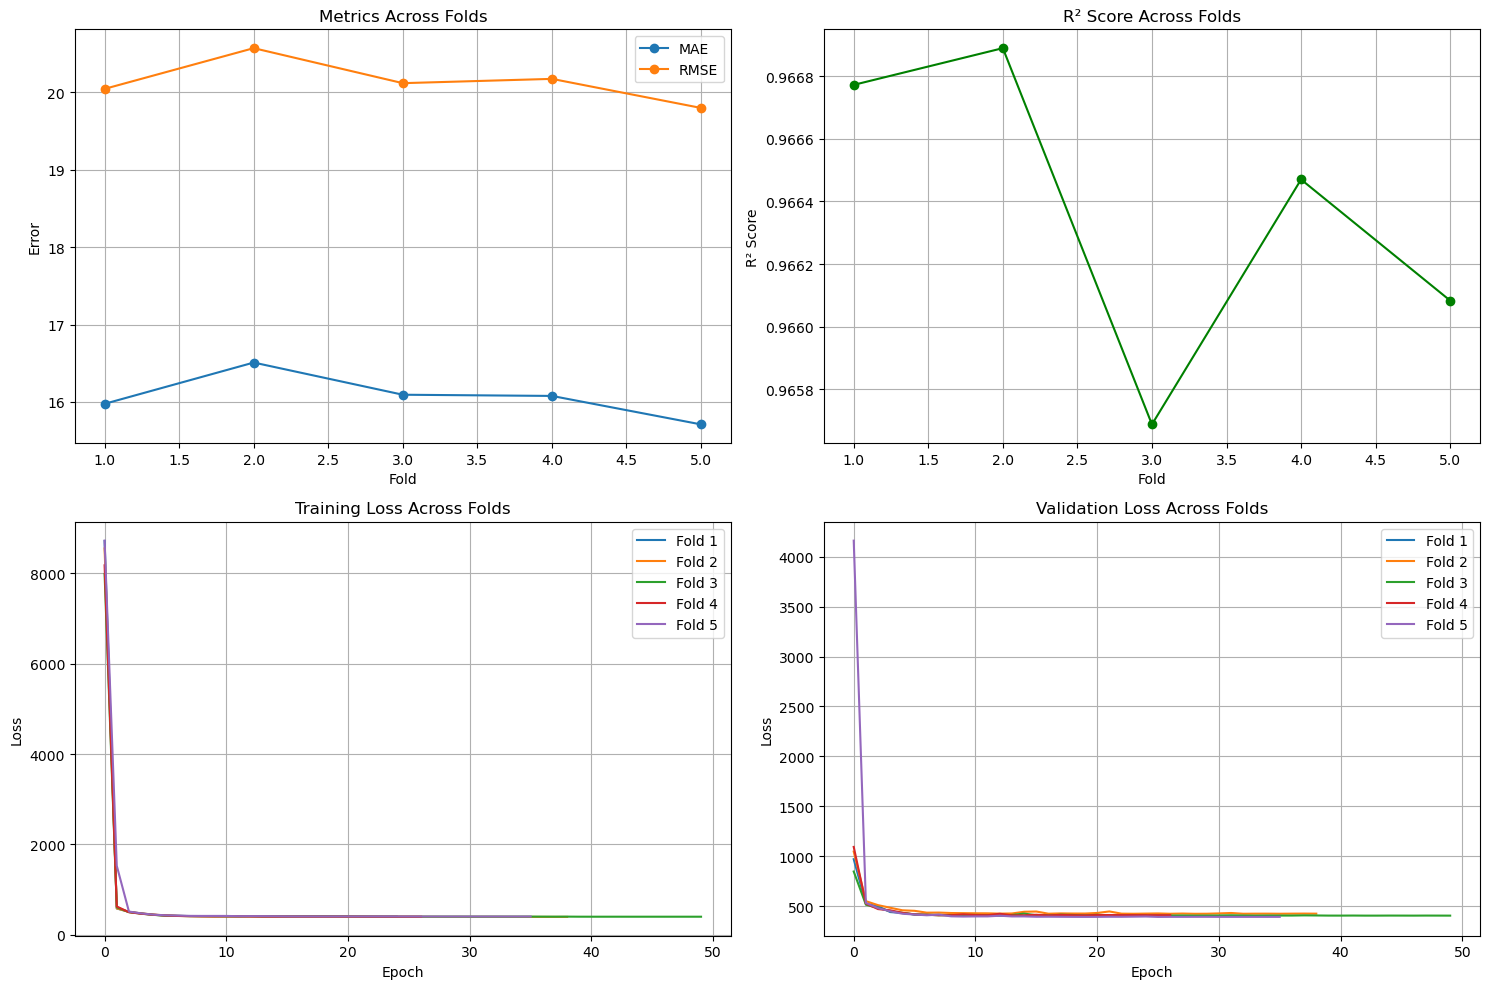

In [40]:
# Then use it in both places:

# model.compile(**get_compile_settings())
# best_model.compile(**get_compile_settings())


# Perform cross-validation and get the best model
best_model, cv_scores = cross_validate_model_with_details(X_train_scaled, y_train)

In [42]:
# The model is already compiled, but you can recompile if you want to change settings
best_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mean_squared_error',
    metrics=['mae']
)


# Train the best model architecture on full training data
history = best_model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[
        EarlyStopping(monitor='val_loss',
                      patience=10, 
                      restore_best_weights=True
                     ),
        
        ReduceLROnPlateau(monitor='val_loss',
                          factor=0.2,
                          patience=5,
                          min_lr=0.00001
                         )
    ],
    verbose=1
)

Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 412.3465 - mae: 16.2894 - val_loss: 387.2426 - val_mae: 15.6693 - learning_rate: 0.0010
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 404.1133 - mae: 16.0835 - val_loss: 385.8086 - val_mae: 15.6316 - learning_rate: 0.0010
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 419.9729 - mae: 16.3431 - val_loss: 385.4337 - val_mae: 15.5940 - learning_rate: 0.0010
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 418.3869 - mae: 16.3939 - val_loss: 384.8087 - val_mae: 15.6081 - learning_rate: 0.0010
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 420.7115 - mae: 16.4694 - val_loss: 382.2078 - val_mae: 15.5614 - learning_rate: 0.0010
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 423.0012 - mae: 16.3760 - val_loss: 391.9739 - val_mae: 15.8008 - learning_rate: 0.0010
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 405.5657 - mae: 16.1652 - val_loss: 384.1259 - val_m


Final Model Performance on Test Set:
MAE: 15.8775
RMSE: 19.9657
R² Score: 0.9673


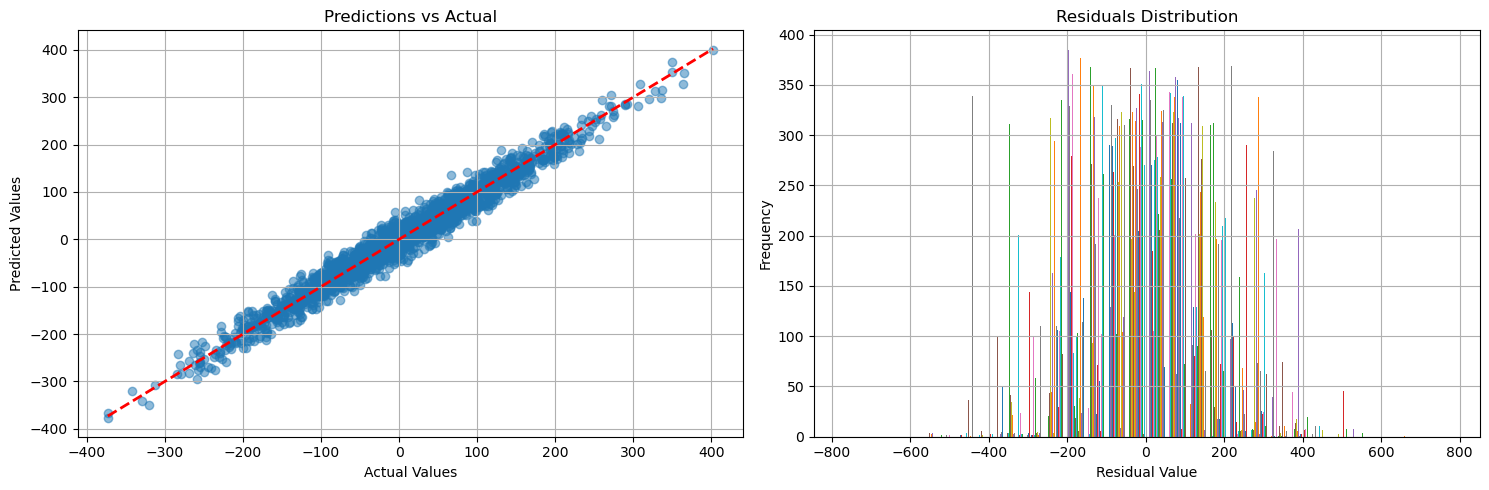

In [43]:
# Evaluate final model on test data
final_metrics = final_model_evaluation(best_model,
                                       X_test_scaled,
                                       y_test
                                      )

In [69]:
def plot_residuals_analysis(y_true, y_pred):
    """
    Create comprehensive residual analysis plots
    
    Parameters:
    -----------
    y_true : array-like
        Actual values
    y_pred : array-like
        Predicted values
    """
    # Ensure arrays are flat
    y_true = y_true.ravel()
    y_pred = y_pred.ravel()
    residuals = y_true - y_pred
    
    plt.figure(figsize=(15, 10))
    
    # 1. Residuals vs Predicted Values
    plt.subplot(2, 2, 1)
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residuals vs Predicted Values')
    plt.grid(True)
    
    # 2. Residuals Distribution (with normal curve for comparison)
    plt.subplot(2, 2, 2)
    sns.histplot(residuals, kde=True)
    plt.xlabel('Residual Value')
    plt.ylabel('Frequency')
    plt.title('Residuals Distribution')
    plt.grid(True)
    
    # 3. Q-Q Plot of Residuals
    plt.subplot(2, 2, 3)
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title('Q-Q Plot of Residuals')
    
    # 4. Standardized Residuals vs Predicted Values
    plt.subplot(2, 2, 4)
    standardized_residuals = stats.zscore(residuals)
    plt.scatter(y_pred, standardized_residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.axhline(y=2, color='r', linestyle=':', alpha=0.5)
    plt.axhline(y=-2, color='r', linestyle=':', alpha=0.5)
    plt.xlabel('Predicted Values')
    plt.ylabel('Standardized Residuals')
    plt.title('Standardized Residuals vs Predicted Values')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Print residual statistics
    print("\nResidual Statistics:")
    print(f"Mean of Residuals: {np.mean(residuals):.4f}")
    print(f"Std of Residuals: {np.std(residuals):.4f}")
    print(f"Skewness: {stats.skew(residuals):.4f}")
    print(f"Kurtosis: {stats.kurtosis(residuals):.4f}")

In [70]:
# After making predictions
y_pred = best_model.predict(X_test_scaled)
print(y_pred.shape)
print(y_test.shape)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step
(2000, 1)
(2000, 1)


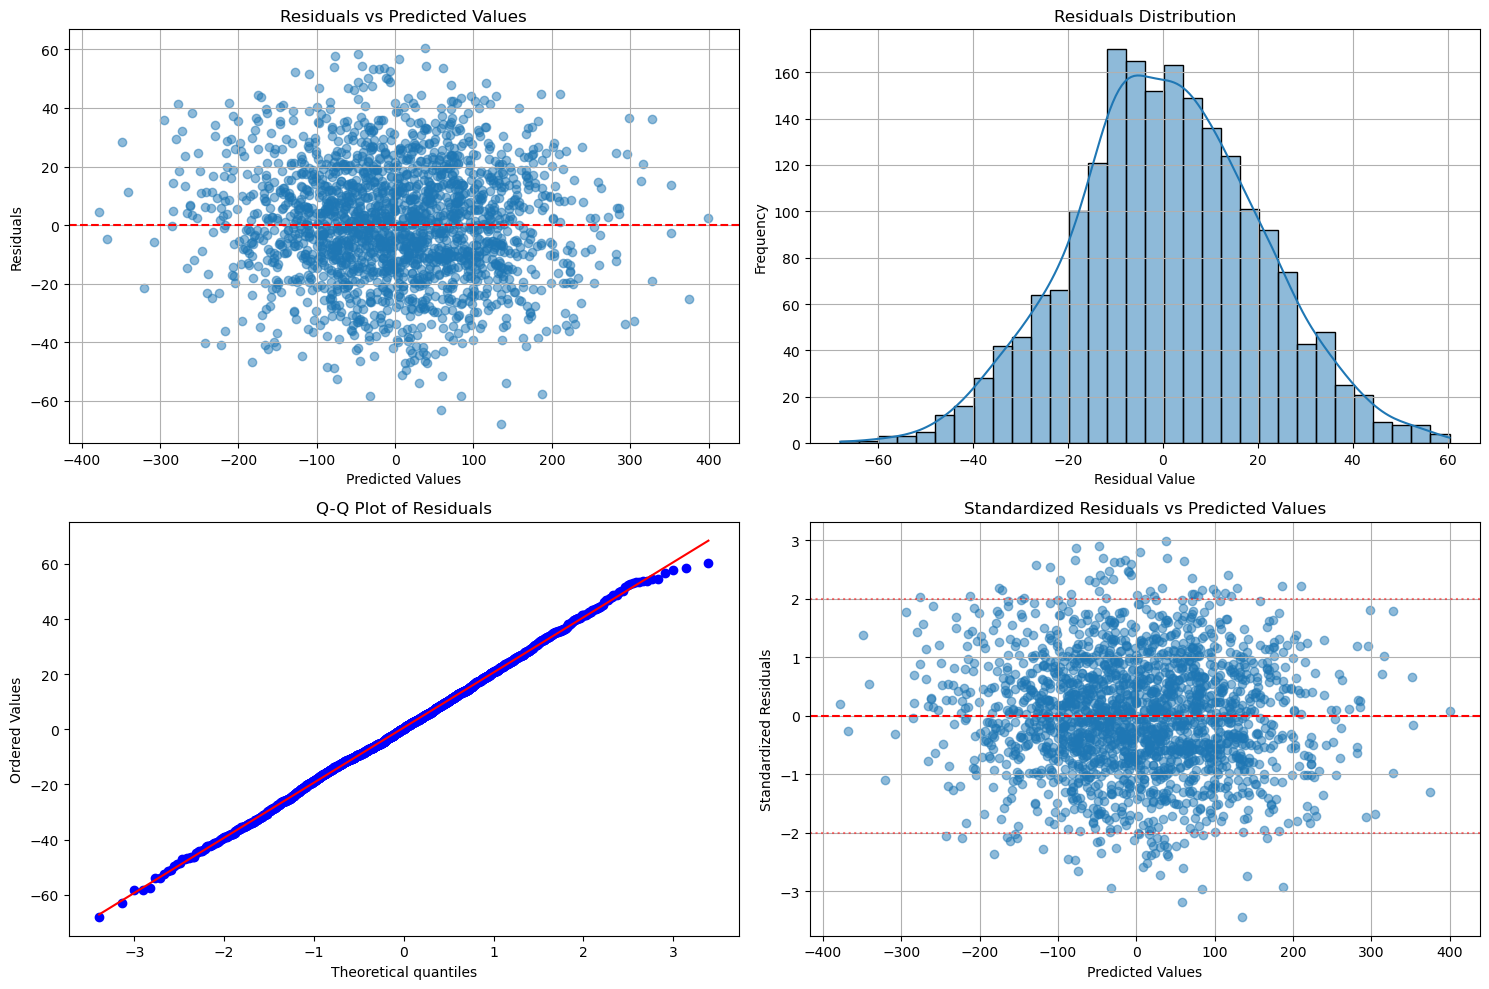


Residual Statistics:
Mean of Residuals: 0.6409
Std of Residuals: 19.9554
Skewness: 0.0155
Kurtosis: -0.0230


In [71]:
plot_residuals_analysis(y_test, y_pred)

---

## Residual Analysis:

In [53]:
def plot_residuals(y_true, y_pred):
    residuals = y_true - y_pred
    
    plt.figure(figsize=(12, 4))
    
    # Residual plot
    plt.subplot(1, 2, 1)
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    
    # Residual distribution
    plt.subplot(1, 2, 2)
    plt.hist(residuals, bins=30)
    plt.xlabel('Residual Value')
    plt.ylabel('Frequency')
    plt.title('Residual Distribution')
    
    plt.tight_layout()
    plt.show()

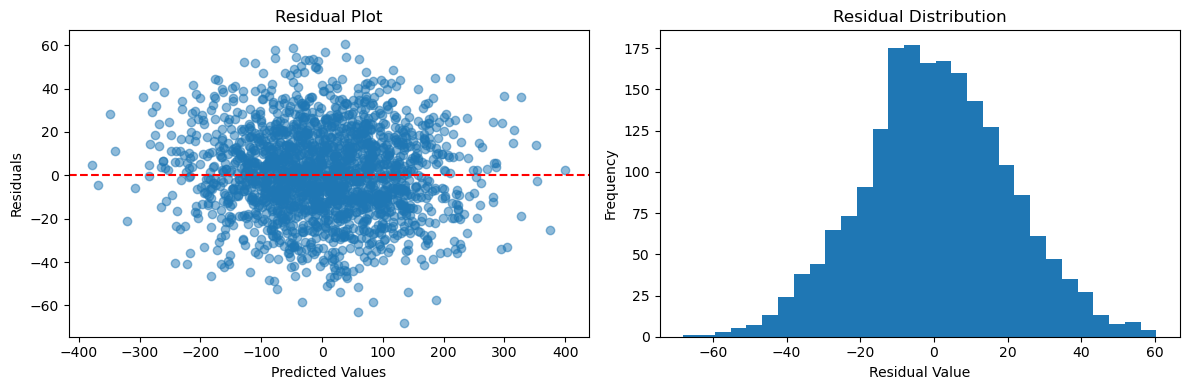

In [54]:
plot_residuals(y_test, y_pred)

In [ ]:
# Feature Importance Analysis (for multiple features):

In [57]:
def analyze_feature_importance(model, X_test, feature_names):
    """
    Basic feature importance using perturbation
    """
    base_pred = model.predict(X_test)
    importance = []
    
    for i in range(X_test.shape[1]):
        # Perturb one feature
        X_perturbed = X_test.copy()
        X_perturbed[:, i] = np.random.permutation(X_perturbed[:, i])
        
        # Measure impact
        perturbed_pred = model.predict(X_perturbed)
        importance.append(root_mean_squared_error(base_pred, perturbed_pred))
    
    # Plot importance
    plt.figure(figsize=(10, 6))
    plt.bar(feature_names, importance)
    plt.xticks(rotation=45)
    plt.xlabel('Features')
    plt.ylabel('Importance (MSE increase when perturbed)')
    plt.title('Feature Importance Analysis')
    plt.tight_layout()
    plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step


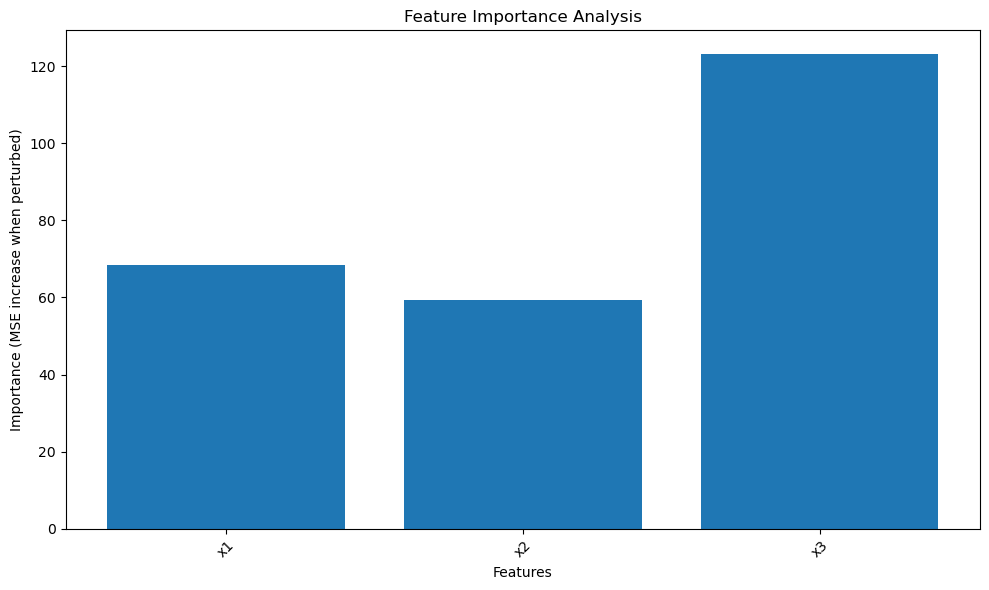

In [58]:
analyze_feature_importance(best_model, X_test, feature_names=['x1', 'x2', 'x3'])

In [59]:
# Model Saving and Loading:
# =======================

# Save model
# model.save('regression_model.keras')

# Load model
# from tensorflow.keras.models import load_model
# loaded_model = load_model('regression_model.keras')